## Using the GPU

In [79]:
import tensorflow as tf

# Check if TensorFlow detects GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# List GPUs
print("Available GPUs:", tf.config.list_physical_devices('GPU'))


Num GPUs Available:  1
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Download The Dataset

In [80]:
import gdown

# Replace FILE_ID with the actual file ID
file_id = "1HHeS_r_fcZJ5CS2EvwOn57s9Q8KNv-dZ"
gdown.download(f"https://drive.google.com/uc?id={file_id}", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1HHeS_r_fcZJ5CS2EvwOn57s9Q8KNv-dZ
From (redirected): https://drive.google.com/uc?id=1HHeS_r_fcZJ5CS2EvwOn57s9Q8KNv-dZ&confirm=t&uuid=2eea6150-3fc6-48a2-b0f5-8403bcfa2ebf
To: /kaggle/working/defungi.zip
100%|██████████| 156M/156M [00:04<00:00, 35.2MB/s] 


'defungi.zip'

## Unzip the the folder 

In [81]:
import zipfile
import os

zip_file_path = '/kaggle/working/defungi.zip'  

output_directory = '/kaggle/working/defungi'  

os.makedirs(output_directory, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(output_directory)

print(f"Files unzipped to: {output_directory}")


Files unzipped to: /kaggle/working/defungi


In [82]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def lenth_images(folder):
    return [f for f in os.listdir(folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    

def show_images(folder):
    # List all image files in the folder
    image_files = [f for f in os.listdir(folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    print('The length of the dataset is ', len(image_files))
    
    # Load a few images for display (e.g., first 9 images)
    images_to_display = image_files[:3]
    
    
    # Set up a grid for displaying images
    plt.figure(figsize=(10, 10))
    
    for i, image_file in enumerate(images_to_display):
        # Open and load the image
        img = Image.open(os.path.join(folder, image_file))
        
        # Add a subplot for each image
        plt.subplot(3, 3, i + 1)  # 3x3 grid
        plt.imshow(img)
        plt.axis('off') 
        plt.title(image_file)
    
    plt.tight_layout()
    plt.show()


## display the Images

In [83]:
H1_folder = "/kaggle/working/defungi/H1"
H2_folder = "/kaggle/working/defungi/H2"
H3_folder = "/kaggle/working/defungi/H3"
H5_folder = "/kaggle/working/defungi/H5"
H6_folder = "/kaggle/working/defungi/H6"

The length of the dataset is  4404


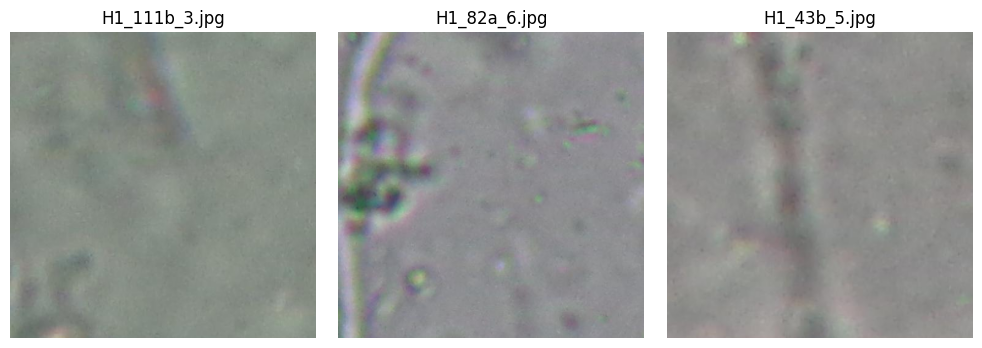

In [84]:
show_images(H1_folder)

The length of the dataset is  2334


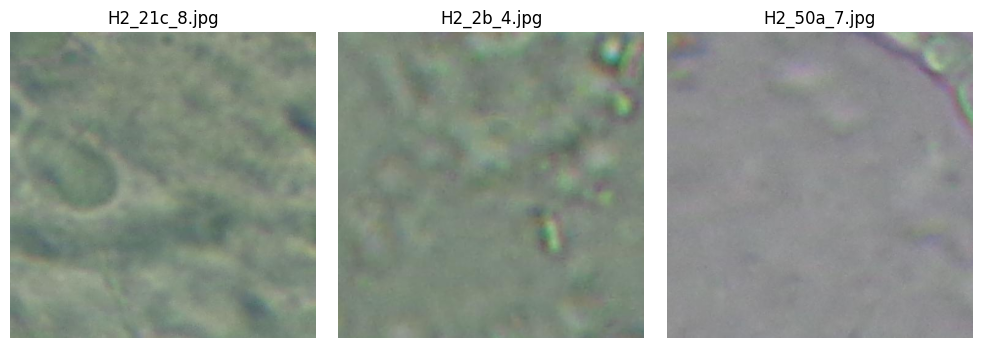

In [85]:
show_images(H2_folder)

The length of the dataset is  819


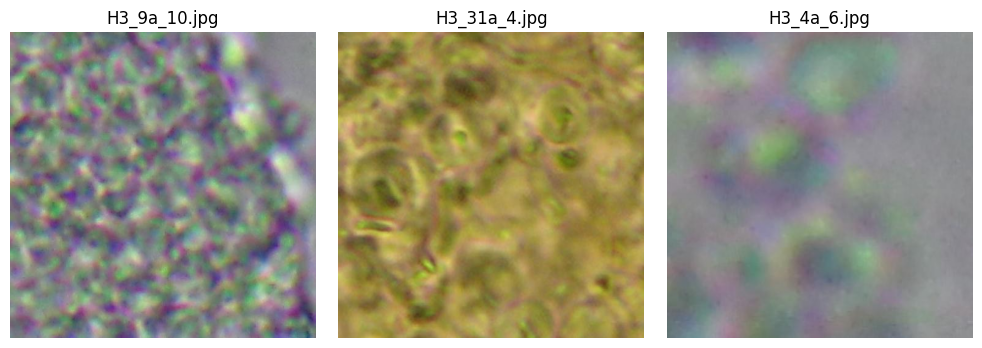

In [86]:
show_images(H3_folder)

The length of the dataset is  818


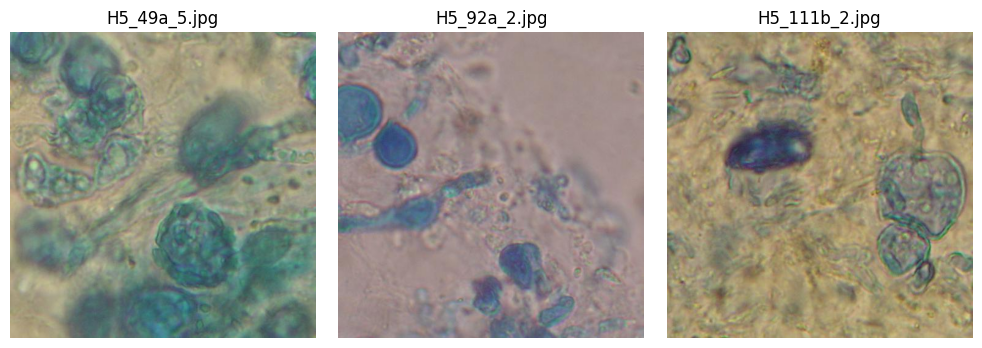

In [87]:
show_images(H5_folder)

The length of the dataset is  739


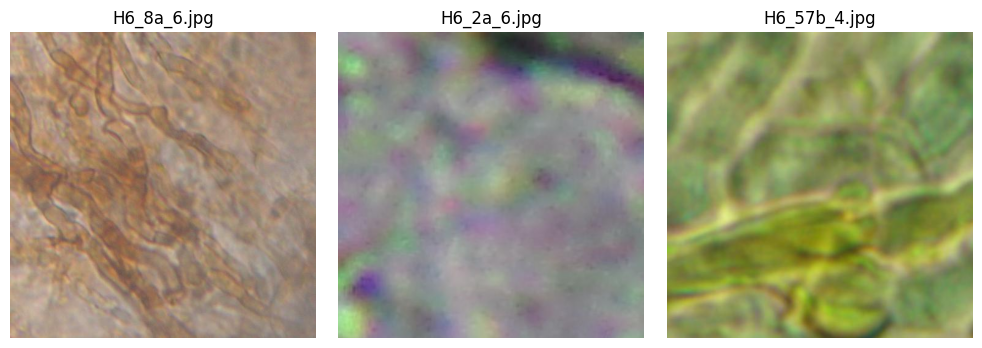

In [88]:
show_images(H6_folder)

## Spliting The Dataset Into Train Test Val

In [89]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Path to your dataset
dataset_dir = "/kaggle/working/defungi"
output_dir = "/kaggle/working/Spliting"  # Where train/val/test folders will be created

# Parameters
test_split = 0.2  
seed = 123

# Create output directories
os.makedirs(output_dir, exist_ok=True)
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "validation")
test_dir = os.path.join(output_dir, "test")
for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)

# Collect all image paths and labels
def get_file_paths_and_labels(dataset_dir):
    all_image_paths = []
    all_labels = []
    class_names = sorted(os.listdir(dataset_dir))
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                if file_path.endswith(('png', 'jpg', 'jpeg')):
                    all_image_paths.append(file_path)
                    all_labels.append(class_name)
    return all_image_paths, all_labels, class_names

image_paths, labels, class_names = get_file_paths_and_labels(dataset_dir)

# Split into train, validation, and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=test_split, stratify=labels, random_state=seed
)

# Function to copy files to destination folders
def copy_files(file_paths, labels, dest_dir):
    for file_path, label in zip(file_paths, labels):
        label_dir = os.path.join(dest_dir, label)
        os.makedirs(label_dir, exist_ok=True)  
        shutil.copy(file_path, label_dir)  # Copy the file to the class folder

# Copy files to respective folders
copy_files(train_paths, train_labels, train_dir)
copy_files(test_paths, test_labels, test_dir)

# Print summary
print(f"Train samples: {len(train_paths)}")
print(f"Test samples: {len(test_paths)}")
print(f"Data split into folders: {output_dir}")


Train samples: 7291
Test samples: 1823
Data split into folders: /kaggle/working/Spliting


## Setting the Parameters for the model

In [90]:
TRAIN_BATCH_SIZE = 26
TEST_BATCH_SIZE = 20
NUM_CLASSES = 5
width, height = 224, 224  # ResNet50 standard input size

In [91]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

def create_model(trainable_base=False):
    # Load pre-trained ResNet50 model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(width, height, 3))

    # Set trainable status for base model
    for layer in base_model.layers:
        layer.trainable = trainable_base
     # Get the output of the base model
    base_output = base_model.output

    # Add custom layers on top of ResNet50
    x = layers.GlobalAveragePooling2D()(base_output)  # Pass base_model's output to this layer
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    # Define the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.00001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


## Use ResNet50 model

In [92]:
model = create_model()
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 1,051,653 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [93]:
# Load datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(width, height),
     label_mode="categorical" ,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True, 

)


test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(width, height),
    label_mode="categorical",
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,  

)

# Extract and store class names
class_names = test_dataset.class_names
print("Class names:", class_names)  

Found 7291 files belonging to 5 classes.
Found 1823 files belonging to 5 classes.
Class names: ['H1', 'H2', 'H3', 'H5', 'H6']


## Normalization the data

In [94]:
# Normalize pixel values
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    
    return image, label

## Apply data augmentation

In [95]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

def augment(image, label):
    image = data_augmentation(image)
    return image, label

# Apply normalization and augmentation
train_dataset = train_dataset.map(normalize).map(augment)
test_dataset = test_dataset.map(normalize).map(augment)

In [96]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=100, 
    steps_per_epoch=80,
)

Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 32s 293ms/step - accuracy: 0.2939 - loss: 9.7826
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 293ms/step - accuracy: 0.4145 - loss: 9.2768
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 293ms/step - accuracy: 0.3809 - loss: 8.9389
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - accuracy: 0.3918 - loss: 8.6471
Epoch 5/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 295ms/step - accuracy: 0.4243 - loss: 8.3949
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 292ms/step - accuracy: 0.4107 - loss: 8.0662
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 294ms/step - accuracy: 0.4097 - loss: 7.7957
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 0.4419 - loss: 7.4964
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 292ms/step - accuracy: 0.4110 - loss: 7.3259
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 294ms/step - accuracy: 0.4419 - loss: 7.0316
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 291ms/step - accuracy: 0.4291 - loss: 6.7994
Epoch 12/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 0.4241 - loss: 6.5468
Epoch 13/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 291ms/step - accuracy: 0.4358 - loss: 6.3877
Epoch 14/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 297ms/step - accuracy: 0.4687 - loss: 6.1364
Epoch 15/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 296ms/step - accuracy: 0.4402 - loss: 5.9698
Epoch 16/100
80/80 ━━━━━━━━━━━━━━━━━━━

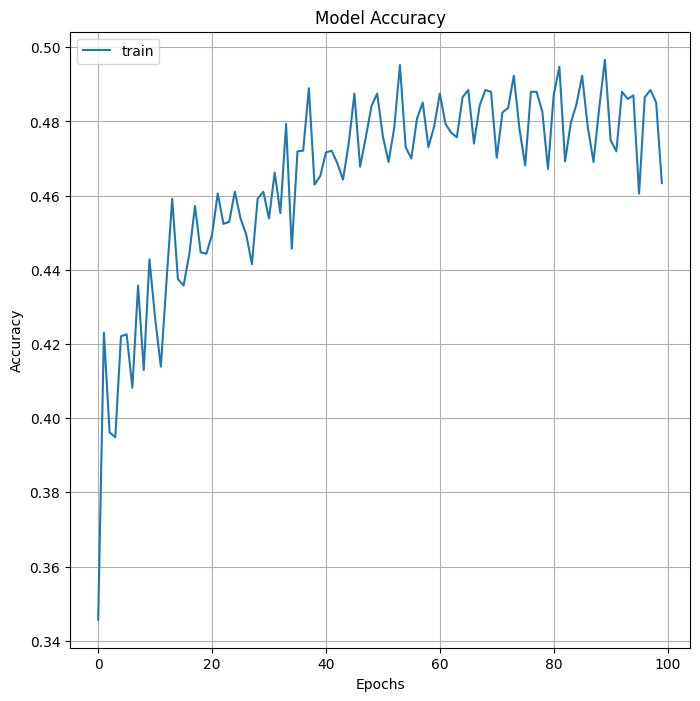

In [97]:
# Plot training history
plt.figure(figsize=(8, 8))
epochs_range = range(100)
plt.plot(epochs_range, history.history['accuracy'], label="Training Accuracy")

plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train'])
plt.show()

## Unfreeze the base model (Fine-Tuning Phase)

In [98]:
fine_tunnig_model= create_model(trainable_base=True)

# Fine-tune the model (train all layers)
history_fine_tuning = fine_tunnig_model.fit(
    train_dataset,
    epochs=200, 
    steps_per_epoch=80,
)


Epoch 1/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 70s 292ms/step - accuracy: 0.2901 - loss: 9.9418
Epoch 2/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 295ms/step - accuracy: 0.5413 - loss: 9.2889
Epoch 3/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 298ms/step - accuracy: 0.5827 - loss: 9.1122
Epoch 4/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.6078 - loss: 8.9586
Epoch 5/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 288ms/step - accuracy: 0.6351 - loss: 8.8425
Epoch 6/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 291ms/step - accuracy: 0.6425 - loss: 8.7575
Epoch 7/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.6684 - loss: 8.6230
Epoch 8/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 0.6727 - loss: 8.5481
Epoch 9/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.6882 - loss: 8.4688
Epoch 10/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.6894 - loss: 8.3998
Epoch 11/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 289ms/step - accuracy: 0.7123 - loss: 8.2861
Epoch 12/200
80/80 ━━━━━━━━━━━

## Plot training history

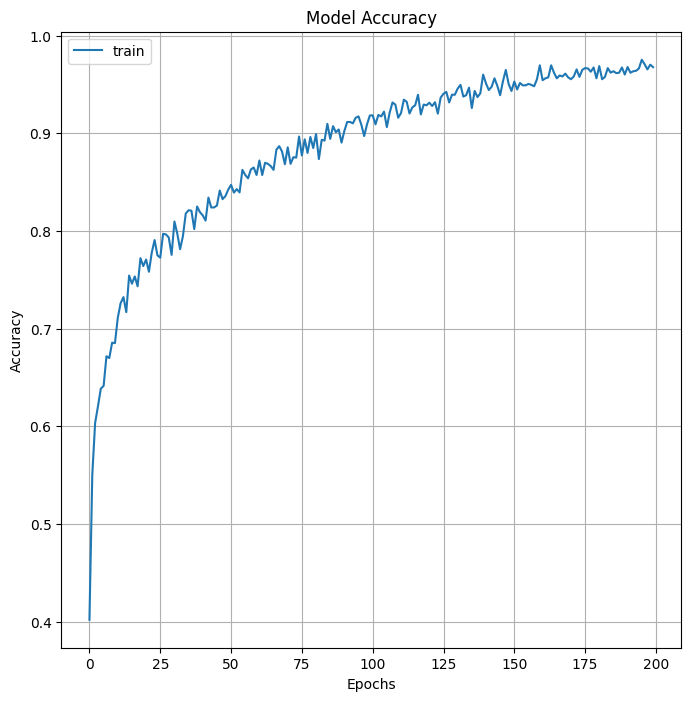

In [99]:
# Plot training history
plt.figure(figsize=(8, 8))
epochs_range = range(200)
plt.plot(epochs_range, history_fine_tuning.history['accuracy'], label="Training Accuracy")

plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train'])
plt.show()


In [100]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(width, height),
    batch_size=16,
    shuffle=False,
    label_mode="categorical"
)
test_dataset = test_dataset.map(normalize).map(augment)
fine_tunnig_model.evaluate(test_dataset)


Found 1823 files belonging to 5 classes.
114/114 ━━━━━━━━━━━━━━━━━━━━ 25s 189ms/step - accuracy: 0.9097 - loss: 1.2292


[1.262030005455017, 0.9034558534622192]

In [101]:
from sklearn.metrics import precision_score, roc_auc_score, classification_report
import numpy as np

# Get predictions on the test dataset
y_pred_probs = fine_tunnig_model.predict(test_dataset)  
y_pred = np.argmax(y_pred_probs, axis=1)  
# Get true labels from the test dataset
y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)  # Integer class labels

# Ensure y_true is integer-encoded if it's one-hot
if y_true.ndim > 1:  
    y_true = np.argmax(y_true, axis=1)

# Accuracy
accuracy = np.mean(y_pred == y_true)
print(f"Accuracy: {accuracy:.4f}")

# Precision (weighted average to account for class imbalance)
precision = precision_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_true, y_pred, average='weighted') 
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(y_true, y_pred, average='weighted') 
print(f"F1 Score: {f1:.4f}")


# AUC (multi-class, one-vs-all strategy)
try:
    auc = roc_auc_score(
        tf.keras.utils.to_categorical(y_true, num_classes=y_pred_probs.shape[1]),
        y_pred_probs,
        multi_class='ovr'
    )
    print(f"AUC: {auc:.4f}")
except ValueError as e:
    print("Error calculating AUC:", e)

print("\nClassification Report:")
print(classification_report(y_true, y_pred))


114/114 ━━━━━━━━━━━━━━━━━━━━ 26s 199ms/step
Accuracy: 0.9095
Precision: 0.9098
Recall: 0.9095
F1 Score: 0.9095
AUC: 0.9868

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       881
           1       0.86      0.84      0.85       467
           2       0.85      0.91      0.88       164
           3       0.97      0.96      0.97       163
           4       0.98      0.95      0.97       148

    accuracy                           0.91      1823
   macro avg       0.92      0.92      0.92      1823
weighted avg       0.91      0.91      0.91      1823

